In [1]:
from torch import nn, optim
from torch.utils.data import DataLoader
import torch
import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn.functional as F
from scipy.stats import pearsonr
from train import train_model, test_model
from model_BiLSTM_v1 import BiLSTM
from torch.utils.tensorboard import SummaryWriter

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
new_deepmass_df = pd.read_csv("./data/renewal_deepmass.tsv", sep="\t", low_memory=False)
new_hela1_df = pd.read_csv("./data/renewal_hela1.tsv", sep="\t", low_memory=False)
new_hela2_df = pd.read_csv("./data/renewal_hela2.tsv", sep="\t", low_memory=False)

max_seq_len = 35
max_intens_len = 70

In [4]:
# model setting
input_size = 1
hidden_size = 128
num_layers = 2
output_size = max_intens_len  # 출력 크기는 인텐시티 길이

class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, y_pred, y_true):
        return 1 - self.cosine_similarity(y_pred, y_true).mean()

# 손실 함수 및 옵티마이저
criterion = CosineSimilarityLoss()

### #2 60:20:20 Training:Validation:Test

In [6]:
pre_trained_model2 = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
pre_trained_model2.load_state_dict(torch.load("./pre_trained_model_parameters_60_80.pth", map_location=torch.device(device)))

tb_writer = SummaryWriter("./tensorboard_logs/version2/trial1-fine_tuning_#2")

# fine tuning dataset
tuning_train_df, tuning_val_test_df = train_test_split(new_hela1_df, test_size=0.4, random_state=44)
tuning_val_df, tuning_test_df = train_test_split(tuning_val_test_df, test_size=0.5, random_state=44)
print(len(tuning_train_df), len(tuning_val_df), len(tuning_test_df))

tuning_train_dataset = preprocessing.retrieve_dataset(tuning_train_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_val_dataset = preprocessing.retrieve_dataset(tuning_val_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_test_dataset = preprocessing.retrieve_dataset(tuning_test_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_train_dataloader = DataLoader(tuning_train_dataset, batch_size=2048, shuffle=True)
tuning_val_dataloader = DataLoader(tuning_val_dataset, batch_size=128, shuffle=True)
tuning_test_dataloader = DataLoader(tuning_test_dataset, batch_size=128, shuffle=True)

# other test dataset
hela2_dataset = preprocessing.retrieve_dataset(new_hela2_df, max_seq_len, max_intens_len, normalize_intens=True)
hela2_dataloader = DataLoader(hela2_dataset, batch_size=128, shuffle=True)

epochs = 300
optimizer = optim.Adam(pre_trained_model2.parameters(), lr=0.001)
tuning_model, tuning_train_res = train_model(pre_trained_model2, criterion, optimizer, epochs, tuning_train_dataloader, tuning_val_dataloader, device, tb_writer, 40)

test_res = test_model(tuning_model, criterion, tuning_test_dataloader, device, tb_writer, "hela 20% test")
hela2_res = test_model(tuning_model, criterion, hela2_dataloader, device, tb_writer, "hela2 test")
tb_writer.close()

10057 3352 3353
Epoch [1/300], Train Loss: 0.1823, Validation Loss: 0.1655
Train Cosine Similarity: 0.8166, Train PCC: 0.7974
Validation Cosine Similarity: 0.8347, Validation PCC: 0.8162
Epoch [2/300], Train Loss: 0.1092, Validation Loss: 0.1269
Train Cosine Similarity: 0.8908, Train PCC: 0.8794
Validation Cosine Similarity: 0.8736, Validation PCC: 0.8601
Epoch [3/300], Train Loss: 0.0994, Validation Loss: 0.1210
Train Cosine Similarity: 0.9005, Train PCC: 0.8904
Validation Cosine Similarity: 0.8789, Validation PCC: 0.8658
Epoch [4/300], Train Loss: 0.0904, Validation Loss: 0.1319
Train Cosine Similarity: 0.9096, Train PCC: 0.9006
Validation Cosine Similarity: 0.8680, Validation PCC: 0.8534
Epoch [5/300], Train Loss: 0.0864, Validation Loss: 0.1250
Train Cosine Similarity: 0.9135, Train PCC: 0.9051
Validation Cosine Similarity: 0.8745, Validation PCC: 0.8608
Epoch [6/300], Train Loss: 0.0822, Validation Loss: 0.1204
Train Cosine Similarity: 0.9178, Train PCC: 0.9099
Validation Cosine S

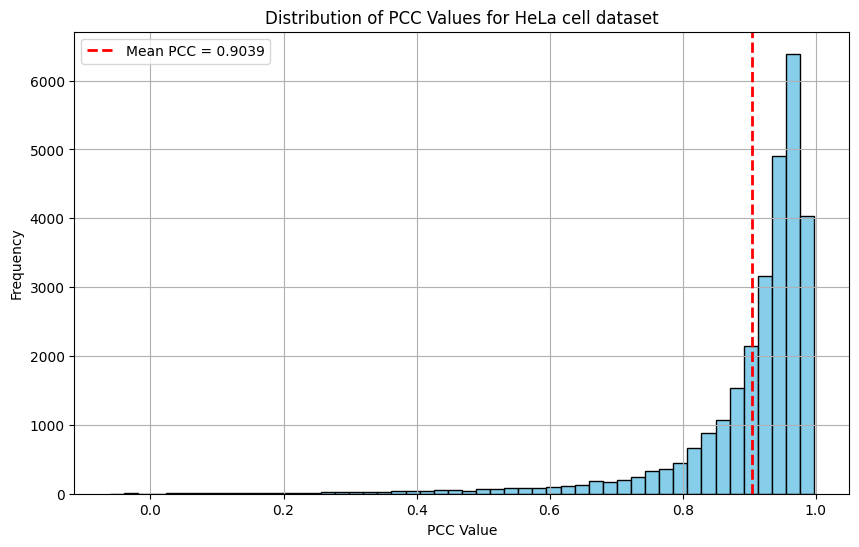

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# PCC 분포 데이터
# pcc_distribution = test_res["pcc_dist"]
pcc_distribution = hela2_res["pcc_dist"]
mean_pearson_coefficient = np.mean(hela2_res["pcc_dist"])

# PCC 분포 그리기
plt.figure(figsize=(10, 6))
plt.hist(pcc_distribution, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_pearson_coefficient, color='red', linestyle='--', linewidth=2, label=f'Mean PCC = {mean_pearson_coefficient:.4f}')
plt.title('Distribution of PCC Values for HeLa cell dataset')
plt.xlabel('PCC Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### #3 40:30:30 Training:Validation:Test

In [6]:
pre_trained_model3 = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
pre_trained_model3.load_state_dict(torch.load("./pre_trained_model_parameters_60_80.pth", map_location=torch.device(device)))

tb_writer = SummaryWriter("./tensorboard_logs/version2/trial1-fine_tuning_#3")

# fine tuning dataset
tuning_train_df, tuning_val_test_df = train_test_split(new_hela1_df, test_size=0.6, random_state=44)
tuning_val_df, tuning_test_df = train_test_split(tuning_val_test_df, test_size=0.5, random_state=44)
print(len(tuning_train_df), len(tuning_val_df), len(tuning_test_df))

tuning_train_dataset = preprocessing.retrieve_dataset(tuning_train_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_val_dataset = preprocessing.retrieve_dataset(tuning_val_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_test_dataset = preprocessing.retrieve_dataset(tuning_test_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_train_dataloader = DataLoader(tuning_train_dataset, batch_size=2048, shuffle=True)
tuning_val_dataloader = DataLoader(tuning_val_dataset, batch_size=128, shuffle=True)
tuning_test_dataloader = DataLoader(tuning_test_dataset, batch_size=128, shuffle=True)

# other test dataset
hela2_dataset = preprocessing.retrieve_dataset(new_hela2_df, max_seq_len, max_intens_len, normalize_intens=True)
hela2_dataloader = DataLoader(hela2_dataset, batch_size=128, shuffle=True)

epochs = 300
optimizer = optim.Adam(pre_trained_model3.parameters(), lr=0.0001)
tuning_model, tuning_train_res = train_model(pre_trained_model3, criterion, optimizer, epochs, tuning_train_dataloader, tuning_val_dataloader, device, tb_writer, 40)

test_res = test_model(tuning_model, criterion, tuning_test_dataloader, device, tb_writer, "hela 30% test")
hela2_res = test_model(tuning_model, criterion, hela2_dataloader, device, tb_writer, "hela2 test")
tb_writer.close()

Epoch [1/300], Train Loss: 0.2811, Validation Loss: 0.2549
Train Cosine Similarity: 0.7161, Train PCC: 0.6869
Validation Cosine Similarity: 0.7453, Validation PCC: 0.7189
Epoch [2/300], Train Loss: 0.2440, Validation Loss: 0.2203
Train Cosine Similarity: 0.7527, Train PCC: 0.7271
Validation Cosine Similarity: 0.7801, Validation PCC: 0.7572
Epoch [3/300], Train Loss: 0.2088, Validation Loss: 0.1889
Train Cosine Similarity: 0.7865, Train PCC: 0.7644
Validation Cosine Similarity: 0.8115, Validation PCC: 0.7919
Epoch [4/300], Train Loss: 0.1802, Validation Loss: 0.1615
Train Cosine Similarity: 0.8167, Train PCC: 0.7979
Validation Cosine Similarity: 0.8385, Validation PCC: 0.8219
Epoch [5/300], Train Loss: 0.1575, Validation Loss: 0.1403
Train Cosine Similarity: 0.8420, Train PCC: 0.8259
Validation Cosine Similarity: 0.8597, Validation PCC: 0.8453
Epoch [6/300], Train Loss: 0.1378, Validation Loss: 0.1257
Train Cosine Similarity: 0.8612, Train PCC: 0.8471
Validation Cosine Similarity: 0.874

### #4 30:35:35 Training:Validation:Test

In [7]:
pre_trained_model4 = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
pre_trained_model4.load_state_dict(torch.load("./pre_trained_model_parameters_60_80.pth", map_location=torch.device(device)))

tb_writer = SummaryWriter("./tensorboard_logs/version2/trial1-fine_tuning_#4")

# fine tuning dataset
tuning_train_df, tuning_val_test_df = train_test_split(new_hela1_df, test_size=0.7, random_state=44)
tuning_val_df, tuning_test_df = train_test_split(tuning_val_test_df, test_size=0.5, random_state=44)
print(len(tuning_train_df), len(tuning_val_df), len(tuning_test_df))

tuning_train_dataset = preprocessing.retrieve_dataset(tuning_train_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_val_dataset = preprocessing.retrieve_dataset(tuning_val_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_test_dataset = preprocessing.retrieve_dataset(tuning_test_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_train_dataloader = DataLoader(tuning_train_dataset, batch_size=128, shuffle=True)
tuning_val_dataloader = DataLoader(tuning_val_dataset, batch_size=128, shuffle=True)
tuning_test_dataloader = DataLoader(tuning_test_dataset, batch_size=128, shuffle=True)

# other test dataset
hela2_dataset = preprocessing.retrieve_dataset(new_hela2_df, max_seq_len, max_intens_len, normalize_intens=True)
hela2_dataloader = DataLoader(hela2_dataset, batch_size=128, shuffle=True)

epochs = 300
optimizer = optim.Adam(pre_trained_model4.parameters(), lr=0.0001)
tuning_model, tuning_train_res = train_model(pre_trained_model4, criterion, optimizer, epochs, tuning_train_dataloader, tuning_val_dataloader, device, tb_writer, 40)

test_res = test_model(tuning_model, criterion, tuning_test_dataloader, device, tb_writer, "hela 35% test")
hela2_res = test_model(tuning_model, criterion, hela2_dataloader, device, tb_writer, "hela2 test")
tb_writer.close()

5028 5867 5867
Epoch [1/300], Train Loss: 0.1697, Validation Loss: 0.1020
Train Cosine Similarity: 0.8289, Train PCC: 0.8113
Validation Cosine Similarity: 0.8980, Validation PCC: 0.8877
Epoch [2/300], Train Loss: 0.0961, Validation Loss: 0.0877
Train Cosine Similarity: 0.9042, Train PCC: 0.8948
Validation Cosine Similarity: 0.9123, Validation PCC: 0.9037
Epoch [3/300], Train Loss: 0.0874, Validation Loss: 0.0831
Train Cosine Similarity: 0.9127, Train PCC: 0.9043
Validation Cosine Similarity: 0.9169, Validation PCC: 0.9089
Epoch [4/300], Train Loss: 0.0835, Validation Loss: 0.0804
Train Cosine Similarity: 0.9166, Train PCC: 0.9086
Validation Cosine Similarity: 0.9196, Validation PCC: 0.9118
Epoch [5/300], Train Loss: 0.0810, Validation Loss: 0.0788
Train Cosine Similarity: 0.9191, Train PCC: 0.9114
Validation Cosine Similarity: 0.9213, Validation PCC: 0.9137
Epoch [6/300], Train Loss: 0.0793, Validation Loss: 0.0775
Train Cosine Similarity: 0.9208, Train PCC: 0.9133
Validation Cosine Si

### #5 20:40:40 Training:Validation:Test

In [8]:
pre_trained_model5 = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
pre_trained_model5.load_state_dict(torch.load("./pre_trained_model_parameters_60_80.pth", map_location=torch.device(device)))

tb_writer = SummaryWriter("./tensorboard_logs/version2/trial1-fine_tuning_#5")

# fine tuning dataset
tuning_train_df, tuning_val_test_df = train_test_split(new_hela1_df, test_size=0.8, random_state=44)
tuning_val_df, tuning_test_df = train_test_split(tuning_val_test_df, test_size=0.5, random_state=44)
print(len(tuning_train_df), len(tuning_val_df), len(tuning_test_df))

tuning_train_dataset = preprocessing.retrieve_dataset(tuning_train_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_val_dataset = preprocessing.retrieve_dataset(tuning_val_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_test_dataset = preprocessing.retrieve_dataset(tuning_test_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_train_dataloader = DataLoader(tuning_train_dataset, batch_size=128, shuffle=True)
tuning_val_dataloader = DataLoader(tuning_val_dataset, batch_size=128, shuffle=True)
tuning_test_dataloader = DataLoader(tuning_test_dataset, batch_size=128, shuffle=True)

# other test dataset
hela2_dataset = preprocessing.retrieve_dataset(new_hela2_df, max_seq_len, max_intens_len, normalize_intens=True)
hela2_dataloader = DataLoader(hela2_dataset, batch_size=128, shuffle=True)

epochs = 300
optimizer = optim.Adam(pre_trained_model5.parameters(), lr=0.0001)
tuning_model, tuning_train_res = train_model(pre_trained_model5, criterion, optimizer, epochs, tuning_train_dataloader, tuning_val_dataloader, device, tb_writer, 40)

test_res = test_model(tuning_model, criterion, tuning_test_dataloader, device, tb_writer, "hela 40% test")
hela2_res = test_model(tuning_model, criterion, hela2_dataloader, device, tb_writer, "hela2 test")
tb_writer.close()

3352 6705 6705
Epoch [1/300], Train Loss: 0.4232, Validation Loss: 0.2017
Train Cosine Similarity: 0.5733, Train PCC: 0.5229
Validation Cosine Similarity: 0.7984, Validation PCC: 0.7756
Epoch [2/300], Train Loss: 0.2677, Validation Loss: 0.1978
Train Cosine Similarity: 0.7304, Train PCC: 0.6966
Validation Cosine Similarity: 0.8021, Validation PCC: 0.7793
Epoch [3/300], Train Loss: 0.2375, Validation Loss: 0.1974
Train Cosine Similarity: 0.7635, Train PCC: 0.7347
Validation Cosine Similarity: 0.8031, Validation PCC: 0.7806
Epoch [4/300], Train Loss: 0.2211, Validation Loss: 0.1949
Train Cosine Similarity: 0.7795, Train PCC: 0.7528
Validation Cosine Similarity: 0.8048, Validation PCC: 0.7824
Epoch [5/300], Train Loss: 0.2086, Validation Loss: 0.1947
Train Cosine Similarity: 0.7909, Train PCC: 0.7656
Validation Cosine Similarity: 0.8054, Validation PCC: 0.7830
Epoch [6/300], Train Loss: 0.2016, Validation Loss: 0.1962
Train Cosine Similarity: 0.8004, Train PCC: 0.7763
Validation Cosine Si

### #6 80:10:10 Training:Validation:Test

In [21]:
pre_trained_model7 = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
pre_trained_model7.load_state_dict(torch.load("./pre_trained_model_parameters_60_80.pth", map_location=torch.device(device)))

tb_writer = SummaryWriter("./tensorboard_logs/version2/trial1-fine_tuning_#6")

# fine tuning dataset
tuning_train_df, tuning_val_test_df = train_test_split(new_hela1_df, test_size=0.3, random_state=12)
tuning_val_df, tuning_test_df = train_test_split(tuning_val_test_df, test_size=0.3, random_state=44)
print(len(tuning_train_df), len(tuning_val_df), len(tuning_test_df))

tuning_train_dataset = preprocessing.retrieve_dataset(tuning_train_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_val_dataset = preprocessing.retrieve_dataset(tuning_val_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_test_dataset = preprocessing.retrieve_dataset(tuning_test_df, max_seq_len, max_intens_len, normalize_intens=True)
tuning_train_dataloader = DataLoader(tuning_train_dataset, batch_size=128, shuffle=True)
tuning_val_dataloader = DataLoader(tuning_val_dataset, batch_size=128, shuffle=True)
tuning_test_dataloader = DataLoader(tuning_test_dataset, batch_size=128, shuffle=True)

# other test dataset
hela2_dataset = preprocessing.retrieve_dataset(new_hela2_df, max_seq_len, max_intens_len, normalize_intens=True)
hela2_dataloader = DataLoader(hela2_dataset, batch_size=128, shuffle=True)

epochs = 300
optimizer = optim.Adam(pre_trained_model7.parameters(), lr=0.0005)
tuning_model, tuning_train_res = train_model(
    pre_trained_model7, criterion, optimizer, epochs, tuning_train_dataloader, tuning_val_dataloader, device, tb_writer, 40)

test_res = test_model(tuning_model, criterion, tuning_test_dataloader, device, tb_writer, "hela 10% test")
hela2_res = test_model(tuning_model, criterion, hela2_dataloader, device, tb_writer, "hela2 test")
tb_writer.close()

11733 3520 1509
Epoch [1/300], Train Loss: 0.0929, Validation Loss: 0.0760
Train Cosine Similarity: 0.9071, Train PCC: 0.8979
Validation Cosine Similarity: 0.9243, Validation PCC: 0.9171
Epoch [2/300], Train Loss: 0.0744, Validation Loss: 0.0728
Train Cosine Similarity: 0.9256, Train PCC: 0.9186
Validation Cosine Similarity: 0.9273, Validation PCC: 0.9205
Epoch [3/300], Train Loss: 0.0715, Validation Loss: 0.0715
Train Cosine Similarity: 0.9285, Train PCC: 0.9218
Validation Cosine Similarity: 0.9284, Validation PCC: 0.9217
Epoch [4/300], Train Loss: 0.0698, Validation Loss: 0.0710
Train Cosine Similarity: 0.9302, Train PCC: 0.9237
Validation Cosine Similarity: 0.9291, Validation PCC: 0.9224
Epoch [5/300], Train Loss: 0.0686, Validation Loss: 0.0708
Train Cosine Similarity: 0.9315, Train PCC: 0.9251
Validation Cosine Similarity: 0.9294, Validation PCC: 0.9228
Epoch [6/300], Train Loss: 0.0678, Validation Loss: 0.0709
Train Cosine Similarity: 0.9322, Train PCC: 0.9259
Validation Cosine S